## UA3 - Filtragem sinais ECG

Eric Lisboa Queiroz

1. Imports e Carregamento do Sinal

Verificando o conteúdo de '/content/ECG-Mio-1.zip'...
Conteúdo do arquivo zip: ['e13mOriginal_500Hz.txt', 'e02mOriginal_500Hz.txt', 'e03mOriginal_500Hz.txt', 'e04mOriginal_500Hz.txt', 'e05mOriginal_500Hz.txt', 'e06mOriginal_500Hz.txt', 'e07mOriginal_500Hz.txt', 'e08mOriginal_500Hz.txt', 'e09mOriginal_500Hz.txt', 'e10mOriginal_500Hz.txt', 'e11mOriginal_500Hz.txt', 'e12mOriginal_500Hz.txt', 'e01mOriginal_500Hz.txt']
Descompactando 'e01mOriginal_500Hz.txt' de '/content/ECG-Mio-1.zip'...
'e01mOriginal_500Hz.txt' descompactado com sucesso.


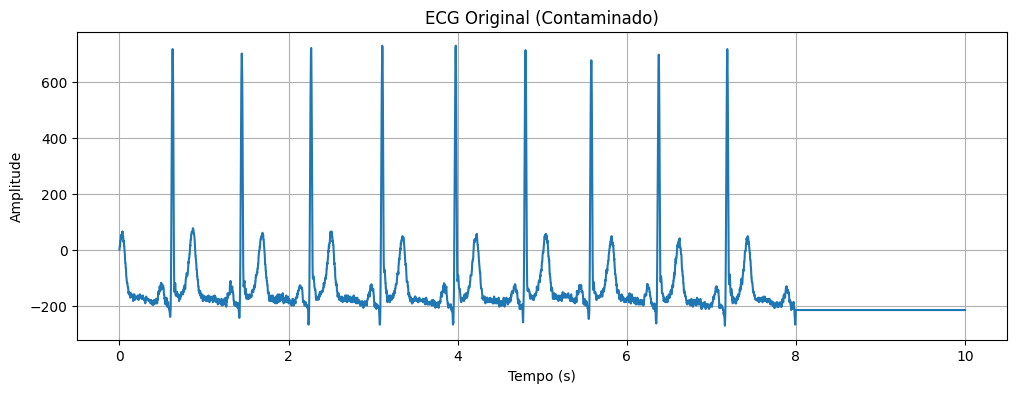

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, freqz
from scipy.fft import fft, fftfreq
import zipfile
import os

# CONFIGURAÇÕES
fs = 500  # ajuste se necessário
arquivo = "e01mOriginal_500Hz.txt"  # alterado para o nome correto do arquivo dentro do zip

# Descompactar o arquivo se for necessário
zip_file_path = "/content/ECG-Mio-1.zip"

# Check if the zip file exists and extract the target file
if os.path.exists(zip_file_path):
    print(f"Verificando o conteúdo de '{zip_file_path}'...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        print(f"Conteúdo do arquivo zip: {file_list}")

        if arquivo in file_list:
            print(f"Descompactando '{arquivo}' de '{zip_file_path}'...")
            zip_ref.extract(arquivo, path='./')
            if os.path.exists(arquivo):
                print(f"'{arquivo}' descompactado com sucesso.")
            else:
                print(f"Erro: Não foi possível descompactar '{arquivo}'.")
        else:
            print(f"Erro: O arquivo '{arquivo}' não foi encontrado dentro de '{zip_file_path}'.")
            print("Por favor, verifique o nome do arquivo ou o conteúdo do zip.")
else:
    print(f"Erro: O arquivo zip '{zip_file_path}' não foi encontrado.")

# Carregar sinal
if os.path.exists(arquivo):
    ecog = np.loadtxt(arquivo)
    N = len(ecog)
    t = np.arange(N) / fs

    plt.figure(figsize=(12,4))
    plt.plot(t, ecog)
    plt.title("ECG Original (Contaminado)")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
else:
    print(f"O arquivo '{arquivo}' não foi encontrado após a tentativa de descompactação. Não foi possível carregar o ECG.")

2. Análise Espectral

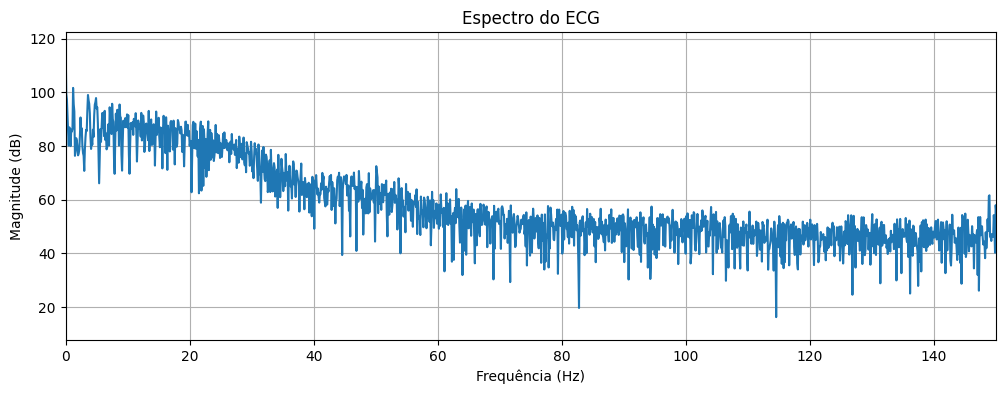

Amplitude em 60 Hz: 58.025394808894944 dB


In [ ]:
# FFT
Y = np.abs(fft(ecog))
freqs = fftfreq(N, 1/fs)

mask = freqs >= 0
freqs_pos = freqs[mask]
Y_pos = Y[mask]

plt.figure(figsize=(12,4))
plt.plot(freqs_pos, 20*np.log10(Y_pos))
plt.title("Espectro do ECG")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.xlim(0,150)
plt.show()

# Identificar 60 Hz
idx_60 = np.argmin(np.abs(freqs_pos - 60))
print("Amplitude em 60 Hz:", 20*np.log10(Y_pos[idx_60]), "dB")

3. Projeto do Filtro Notch

In [ ]:
# Frequência alvo
f0 = 60
w0 = 2*np.pi*f0/fs
r = 0.97  # largura e profundidade do notch

# Coeficientes do filtro
b = np.array([1, -2*np.cos(w0), 1])
a = np.array([1, -2*r*np.cos(w0), r*r])

print("Coeficientes b:", b)
print("Coeficientes a:", a)


Coeficientes b: [ 1.         -1.45793725  1.        ]
Coeficientes a: [ 1.         -1.41419914  0.9409    ]


4. Polos e Zeros

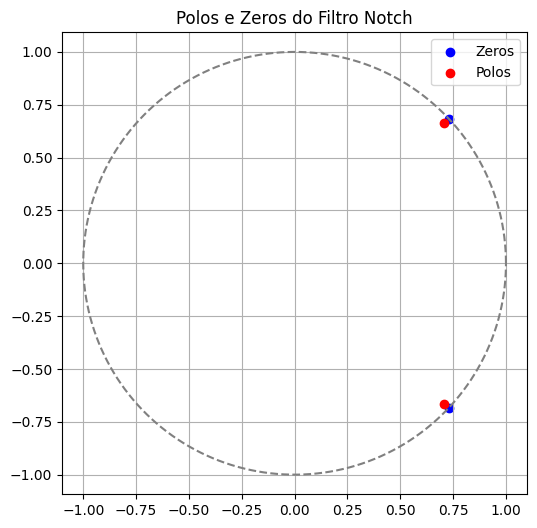

In [ ]:
zeros = np.roots(b)
polos = np.roots(a)

plt.figure(figsize=(6,6))
theta = np.linspace(0,2*np.pi,400)
plt.plot(np.cos(theta), np.sin(theta), '--', color='gray')  # círculo unitário

plt.scatter(np.real(zeros), np.imag(zeros), label="Zeros", color="blue")
plt.scatter(np.real(polos), np.imag(polos), label="Polos", color="red")

plt.title("Polos e Zeros do Filtro Notch")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


5. Resposta em Frequência

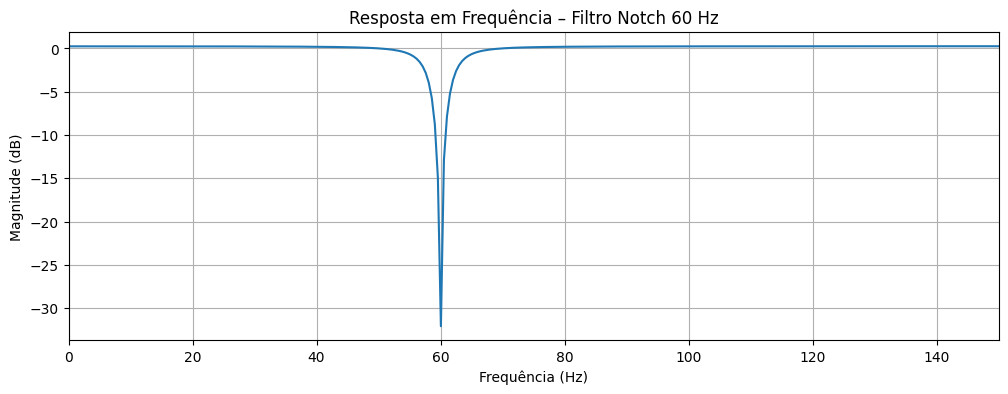

Atenuação exata em 60 Hz: -32.073603947744246 dB


In [ ]:
w, h = freqz(b, a, fs=fs)

plt.figure(figsize=(12,4))
plt.plot(w, 20*np.log10(abs(h)))
plt.title("Resposta em Frequência – Filtro Notch 60 Hz")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.xlim(0,150)
plt.show()

# Atenuação em 60 Hz
idx = np.argmin(np.abs(w - 60))
print("Atenuação exata em 60 Hz:", 20*np.log10(abs(h[idx])), "dB")


6. Largura de banda de 3 dB

In [ ]:
H_mag = 20*np.log10(abs(h))
H_min = H_mag[idx]
threshold = H_min + 3

indices = np.where(H_mag < threshold)[0]
bw = w[indices[-1]] - w[indices[0]]

print("Largura de banda de 3 dB:", bw, "Hz")


Largura de banda de 3 dB: 0.0 Hz


7. Aplicação do Filtro Notch

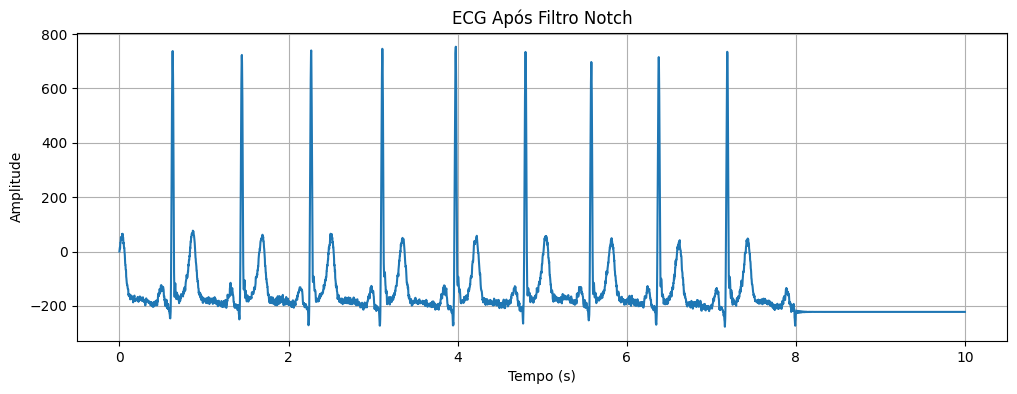

In [ ]:
from scipy.signal import lfilter

ec_notch = lfilter(b, a, ecog)

plt.figure(figsize=(12,4))
plt.plot(t, ec_notch)
plt.title("ECG Após Filtro Notch")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

8. Filtro Butterworth Passa-Baixa

In [ ]:
cutoffs = [30, 40, 50, 60, 70]
ec_lp = {}

for fc in cutoffs:
    b_lp, a_lp = butter(2, fc/(fs/2), btype='low')
    ec_lp[fc] = filtfilt(b_lp, a_lp, ecog)


9. Espectro Após Filtros Passa-Baixa

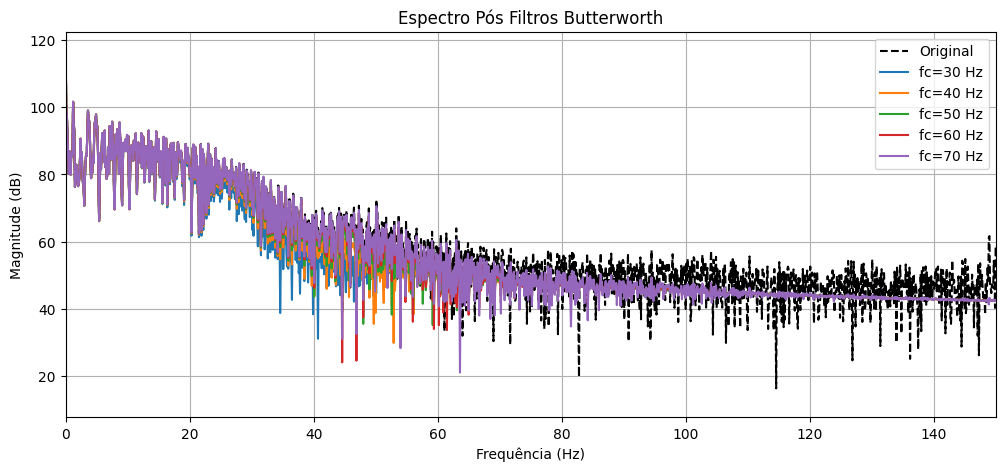

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(freqs_pos, 20*np.log10(Y_pos), 'k--', label="Original")

for fc in cutoffs:
    Yf = np.abs(fft(ec_lp[fc]))[mask]
    plt.plot(freqs_pos, 20*np.log10(Yf), label=f"fc={fc} Hz")

plt.title("Espectro Pós Filtros Butterworth")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend()
plt.xlim(0,150)
plt.show()

10. Visualização do efeito no tempo

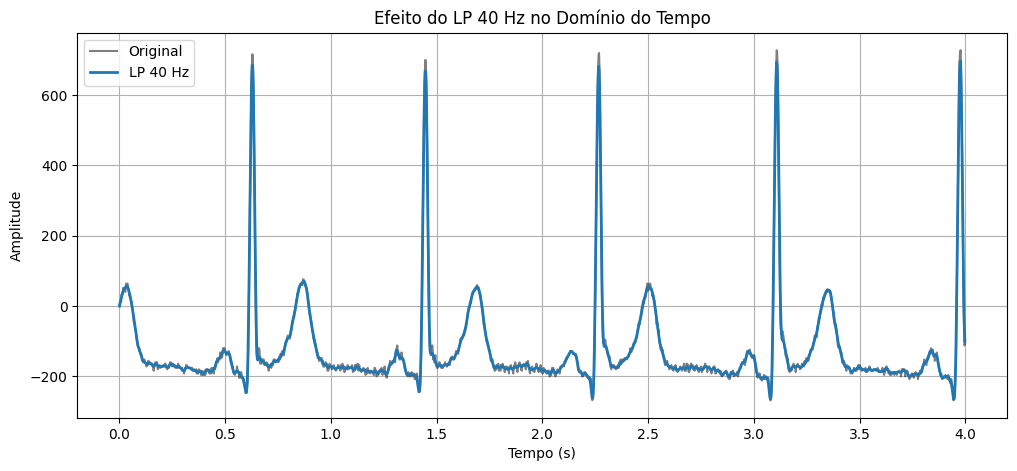

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(t[:2000], ecog[:2000], 'k-', label="Original", alpha=0.5)
plt.plot(t[:2000], ec_lp[40][:2000], label="LP 40 Hz", linewidth=2)

plt.title("Efeito do LP 40 Hz no Domínio do Tempo")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

11. Questionário

1) A atenuação máxima ocorre exatamente na frequência em que os zeros são
   posicionados no círculo unitário: z = e^{±jθ}.
   Como θ = 2π f_notch / fs, a frequência do notch é determinada diretamente
   pela posição angular dos zeros.

2) Os polos precisam estar dentro do círculo unitário (|p| < 1) para garantir
   estabilidade. Se |p| = 1, o filtro é marginalmente estável (oscila para sempre).
   Se |p| > 1, é instável e a saída diverge.

3) O filtro Butterworth pode distorcer o QRS dependendo da frequência de corte.
   Para fc = 40 Hz, a morfologia é preservada.
   Cortes menores (< 30 Hz) suavizam o QRS.
   Cortes maiores (> 50 Hz) deixam passar mais ruído EMG.